In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch

from meta_training import (
    EvaluationConfig,
    MetaTrainingConfig,
    resolve_device,
    run_meta_training,
)
from evaluate_functions import (
    average_accuracy_across_sequences,
    average_correct_retrievals_across_sequences,
    compute_recall_accuracies,
)
from synthetic_datasets import InContextRecallDataset
from meta_optimizers import ManualSGD


In [5]:
training_config = MetaTrainingConfig(
    device_preference="cuda",
    key_dim=10,
    val_dim=10,
    context_dim=5, # inner loss computation window
    seq_len=50,
    num_sequences=1500,
    batch_size=1,
    recall_window=1, # for outer loss computation
    output_corr=0,
    inner_optimizer=ManualSGD(),
    inner_optimizer_kwargs={"lr": 0.01, "beta": 0.9},
    outer_optimizer_kwargs={"lr": 0.01},
    log_every_sequences=50,
    train_lr_model=False,
    train_weight_model=False
)

actual_device = resolve_device(training_config.device_preference)
print(f"--- Starting Training on {actual_device} ---")
artifacts = run_meta_training(training_config, weight_model_override=torch.ones(5),lr_model_override=0.1)
print("--- Training complete ---")


--- Starting Training on cuda ---
Epoch 1 | Avg Outer Loss: 3.6751
  Sample Hyperparams -> LR: 0.1000
Epoch 50 | Avg Outer Loss: 3.6640
  Sample Hyperparams -> LR: 0.1000
Epoch 100 | Avg Outer Loss: 3.6656
  Sample Hyperparams -> LR: 0.1000
Epoch 150 | Avg Outer Loss: 3.6428
  Sample Hyperparams -> LR: 0.1000
Epoch 200 | Avg Outer Loss: 3.6751
  Sample Hyperparams -> LR: 0.1000
Epoch 250 | Avg Outer Loss: 3.6248
  Sample Hyperparams -> LR: 0.1000
Epoch 300 | Avg Outer Loss: 3.6750
  Sample Hyperparams -> LR: 0.1000
Epoch 350 | Avg Outer Loss: 3.6661
  Sample Hyperparams -> LR: 0.1000
Epoch 400 | Avg Outer Loss: 3.6617
  Sample Hyperparams -> LR: 0.1000
Epoch 450 | Avg Outer Loss: 3.6117
  Sample Hyperparams -> LR: 0.1000
Epoch 500 | Avg Outer Loss: 3.6451
  Sample Hyperparams -> LR: 0.1000
Epoch 550 | Avg Outer Loss: 3.6640
  Sample Hyperparams -> LR: 0.1000
Epoch 600 | Avg Outer Loss: 3.6250
  Sample Hyperparams -> LR: 0.1000
Epoch 650 | Avg Outer Loss: 3.6497
  Sample Hyperparams -> 

Weight Distribution Statistics:
  Mean: -0.000964
  Std:  0.019908
  Min:  -0.062990
  Max:  0.063751
  Total weights: 850


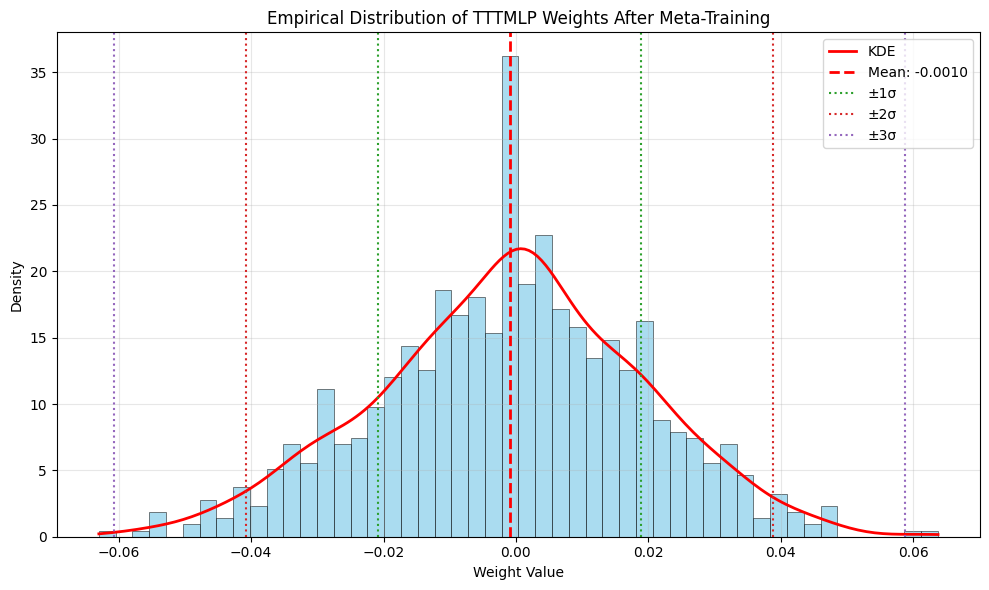


Comparison with initial weight distribution (σ=0.02):
  Expected initial std: 0.0200
  Actual final std: 0.019908
  Std ratio (final/initial): 1.00x


In [6]:
# Extract all weights from the trained memory module
all_weights = []

# Get all parameters from the TTTMLP model
for param_name, param in artifacts.memory_module.named_parameters():
    if param.requires_grad:  # Only include trainable parameters
        weights = param.detach().cpu().numpy().flatten()
        all_weights.extend(weights)

# Convert to numpy array for easier manipulation
all_weights = np.array(all_weights)

# Create the empirical distribution plot
plt.figure(figsize=(10, 6))

# Plot histogram with kernel density estimate
n, bins, patches = plt.hist(all_weights, bins=50, density=True, alpha=0.7, 
                           color='skyblue', edgecolor='black', linewidth=0.5)

# Add kernel density estimate
from scipy import stats
kde = stats.gaussian_kde(all_weights)
x_range = np.linspace(all_weights.min(), all_weights.max(), 200)
plt.plot(x_range, kde(x_range), 'r-', linewidth=2, label='KDE')

# Add vertical line for mean
plt.axvline(all_weights.mean(), color='red', linestyle='--', linewidth=2, 
           label=f'Mean: {all_weights.mean():.4f}')

# Add vertical lines for standard deviations
for i, std in enumerate([1, 2, 3]):
    plt.axvline(all_weights.mean() + std * all_weights.std(), 
               color=f'C{i+2}', linestyle=':', linewidth=1.5, 
               label=f'±{std}σ')
    plt.axvline(all_weights.mean() - std * all_weights.std(), 
               color=f'C{i+2}', linestyle=':', linewidth=1.5)

plt.xlabel('Weight Value')
plt.ylabel('Density')
plt.title('Empirical Distribution of TTTMLP Weights After Meta-Training')
plt.legend()
plt.grid(True, alpha=0.3)

# Print statistics
print("Weight Distribution Statistics:")
print(f"  Mean: {all_weights.mean():.6f}")
print(f"  Std:  {all_weights.std():.6f}")
print(f"  Min:  {all_weights.min():.6f}")
print(f"  Max:  {all_weights.max():.6f}")
print(f"  Total weights: {len(all_weights)}")

plt.tight_layout()
plt.show()

# Additional analysis: Compare with initial weight distribution
print("\nComparison with initial weight distribution (σ=0.02):")
print(f"  Expected initial std: 0.0200")
print(f"  Actual final std: {all_weights.std():.6f}")
print(f"  Std ratio (final/initial): {all_weights.std()/0.02:.2f}x")


--- Recall Accuracy by Offset ---
Offset 0 | Accuracy: 0.091 | Observations: 5000
Offset 1 | Accuracy: 0.074 | Observations: 4900
Offset 2 | Accuracy: 0.061 | Observations: 4800
Offset 3 | Accuracy: 0.056 | Observations: 4700
Offset 4 | Accuracy: 0.051 | Observations: 4600
Offset 5 | Accuracy: 0.049 | Observations: 4500
Offset 6 | Accuracy: 0.047 | Observations: 4400
Offset 7 | Accuracy: 0.044 | Observations: 4300
Offset 8 | Accuracy: 0.042 | Observations: 4200
Offset 9 | Accuracy: 0.040 | Observations: 4100
Offset 10 | Accuracy: 0.040 | Observations: 4000
Offset 11 | Accuracy: 0.038 | Observations: 3900
Offset 12 | Accuracy: 0.037 | Observations: 3800
Offset 13 | Accuracy: 0.036 | Observations: 3700
Offset 14 | Accuracy: 0.034 | Observations: 3600
Offset 15 | Accuracy: 0.033 | Observations: 3500
Offset 16 | Accuracy: 0.033 | Observations: 3400
Offset 17 | Accuracy: 0.032 | Observations: 3300
Offset 18 | Accuracy: 0.032 | Observations: 3200
Offset 19 | Accuracy: 0.031 | Observations: 3

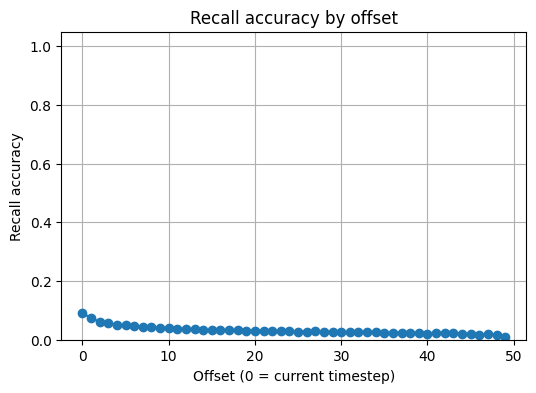

In [7]:
evaluation_config = EvaluationConfig(
    seq_len=training_config.seq_len,
    num_sequences=100,
    key_dim=training_config.key_dim,
    val_dim=training_config.val_dim,
    context_dim=training_config.context_dim,
    output_corr=training_config.output_corr,
)

evaluation_histories = []
for _ in range(evaluation_config.num_sequences):
    dataset = InContextRecallDataset(
        seq_len=evaluation_config.seq_len,
        key_dim=evaluation_config.key_dim,
        val_dim=evaluation_config.val_dim,
        context_size=evaluation_config.context_dim,
        output_corr=evaluation_config.output_corr,
    )
    history = compute_recall_accuracies(
        artifacts.memory_module,
        dataset.inputs,
        dataset.targets,
    )
    evaluation_histories.append(history)

mean_accuracy, counts = average_accuracy_across_sequences(evaluation_histories)
offsets = np.arange(mean_accuracy.shape[0])
mean_accuracy_np = mean_accuracy.detach().cpu().numpy()
counts_np = counts.detach().cpu().numpy()

valid_mask = counts_np > 0
print("--- Recall Accuracy by Offset ---")
for offset, accuracy, count in zip(offsets[valid_mask], mean_accuracy_np[valid_mask], counts_np[valid_mask]):
    print(f"Offset {int(offset)} | Accuracy: {accuracy:.3f} | Observations: {int(count)}")

plt.figure(figsize=(6, 4))
plt.plot(offsets, mean_accuracy_np, marker="o")
plt.xlabel("Offset (0 = current timestep)")
plt.ylabel("Recall accuracy")
plt.title("Recall accuracy by offset")
plt.ylim(0.0, 1.05)
plt.grid(True)
plt.show()


--- Average Correct Retrievals per Timestep ---
Timestep 0 | Avg Correct Retrievals: 1.000 | Sequences: 100
Timestep 1 | Avg Correct Retrievals: 1.060 | Sequences: 100
Timestep 2 | Avg Correct Retrievals: 0.940 | Sequences: 100
Timestep 3 | Avg Correct Retrievals: 0.960 | Sequences: 100
Timestep 4 | Avg Correct Retrievals: 0.930 | Sequences: 100
Timestep 5 | Avg Correct Retrievals: 1.040 | Sequences: 100
Timestep 6 | Avg Correct Retrievals: 1.130 | Sequences: 100
Timestep 7 | Avg Correct Retrievals: 1.130 | Sequences: 100
Timestep 8 | Avg Correct Retrievals: 1.120 | Sequences: 100
Timestep 9 | Avg Correct Retrievals: 1.130 | Sequences: 100
Timestep 10 | Avg Correct Retrievals: 1.160 | Sequences: 100
Timestep 11 | Avg Correct Retrievals: 1.180 | Sequences: 100
Timestep 12 | Avg Correct Retrievals: 1.140 | Sequences: 100
Timestep 13 | Avg Correct Retrievals: 1.100 | Sequences: 100
Timestep 14 | Avg Correct Retrievals: 1.140 | Sequences: 100
Timestep 15 | Avg Correct Retrievals: 1.110 | S

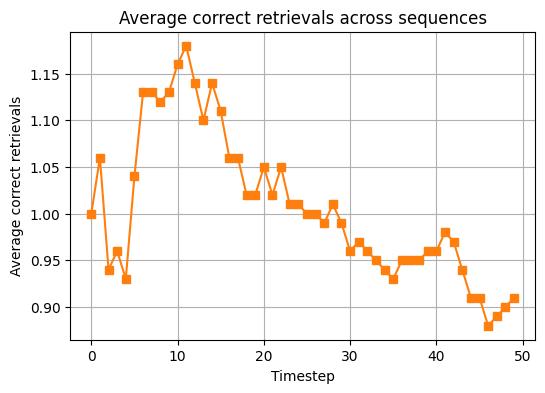

In [8]:
mean_correct_retrievals, contributing_counts = average_correct_retrievals_across_sequences(evaluation_histories)
timesteps = np.arange(mean_correct_retrievals.shape[0])
mean_correct_np = mean_correct_retrievals.detach().cpu().numpy()
contributing_np = contributing_counts.detach().cpu().numpy()

print("--- Average Correct Retrievals per Timestep ---")
for timestep, retrievals, count in zip(timesteps[contributing_np > 0], mean_correct_np[contributing_np > 0], contributing_np[contributing_np > 0]):
    print(f"Timestep {int(timestep)} | Avg Correct Retrievals: {retrievals:.3f} | Sequences: {int(count)}")

plt.figure(figsize=(6, 4))
plt.plot(timesteps, mean_correct_np, marker="s", color="tab:orange")
plt.xlabel("Timestep")
plt.ylabel("Average correct retrievals")
plt.title("Average correct retrievals across sequences")
plt.grid(True)
plt.show()


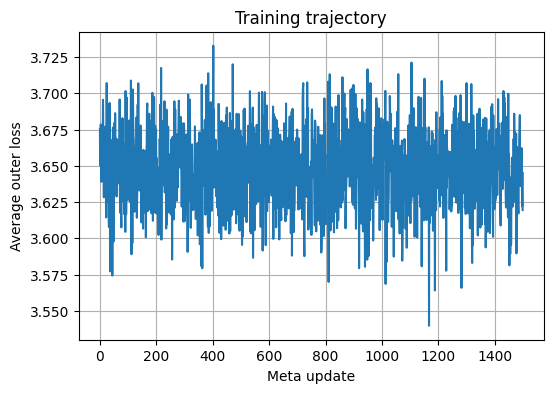

In [9]:
plt.figure(figsize=(6, 4))
plt.plot(np.arange(len(artifacts.outer_losses)), artifacts.outer_losses)
plt.xlabel("Meta update")
plt.ylabel("Average outer loss")
plt.title("Training trajectory")
plt.grid(True)
plt.show()
